In [967]:
%pylab inline
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import linear_model as lm
import statsmodels.api as sm
from sklearn import cross_validation as cv
from sklearn.cross_validation import train_test_split
from sklearn.datasets.samples_generator import make_regression
import statsmodels.stats.api as smf
from sklearn.preprocessing import LabelEncoder

sns.set_style("ticks")
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (15, 12)  
plt.rcParams['figure.dpi'] = (120)  
pd.set_option('display.max_colwidth',52)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [968]:
#Import patient discharge data
df = pd.read_csv('data/patients.csv')
df = df.dropna()
df=df.rename(columns = {'Zip Code - 3 digits':'zip'})
df=df.rename(columns = {'Total Charges':'charges'})

Exploring: Mount Sinai heart cath lab data

Features of the dataset:

Categorical, independent variables: age group, race, gender, source of payment (ex. private vs. medicaid)

Numeric, independent variables: length of hospitalization
Dependent variable: Total Charges

####Median and Mean Charges by Facility/Hospital

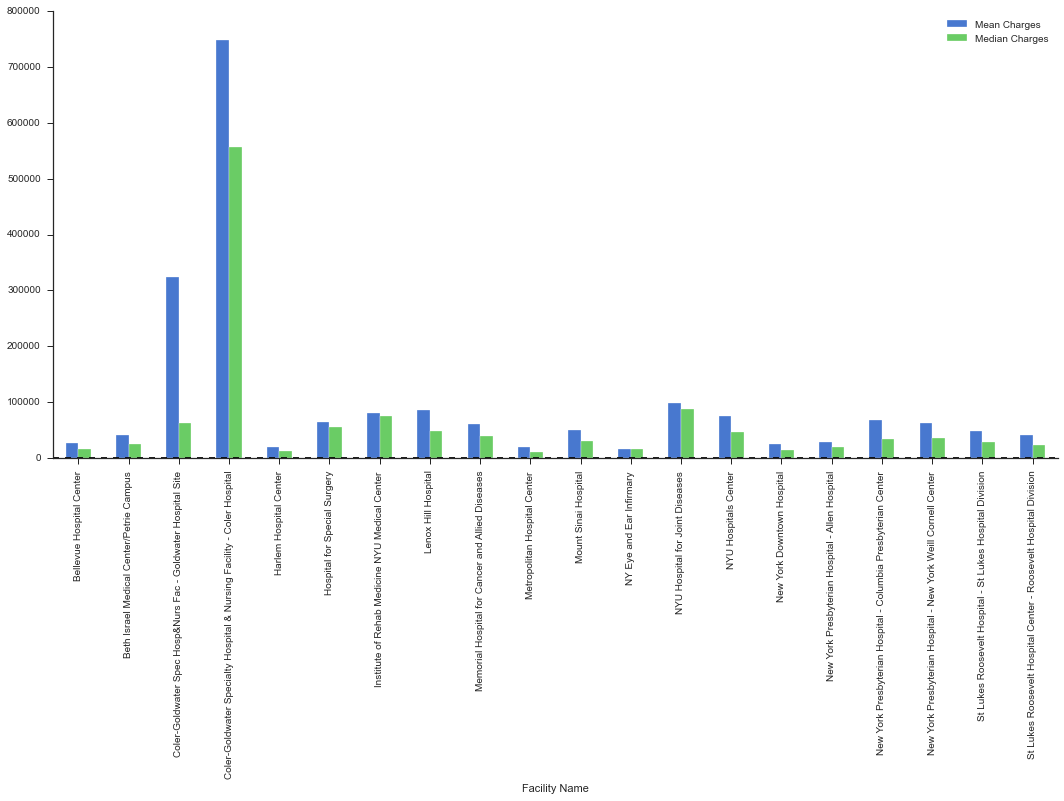

In [969]:
facility = df[['Facility Name','charges']].dropna()
facility_mean = facility.groupby('Facility Name').mean()
facility_median = facility.groupby('Facility Name').median()
facility_mean=facility_mean.rename(columns = {'charges':'Mean Charges'})
facility_median=facility_median.rename(columns = {'charges':'Median Charges'})
facility_median = facility_median['Median Charges']
facility_mandm = facility_mean.join(facility_median)
facility_mandm.plot(kind='bar', figsize=(18,8), grid = False, edgecolor = "white", alpha = 1)
sns.despine()


Remove 'Coler-Goldwater' because its clearly an outlier

In [970]:
df = df[df['Facility Name'] <> 'Coler-Goldwater Spec Hosp&Nurs Fac - Goldwater Hospital Site']
df = df[df['Facility Name'] <> 'Coler-Goldwater Specialty Hospital & Nursing Facility - Coler Hospital']

Recreate plots with new DataFrame

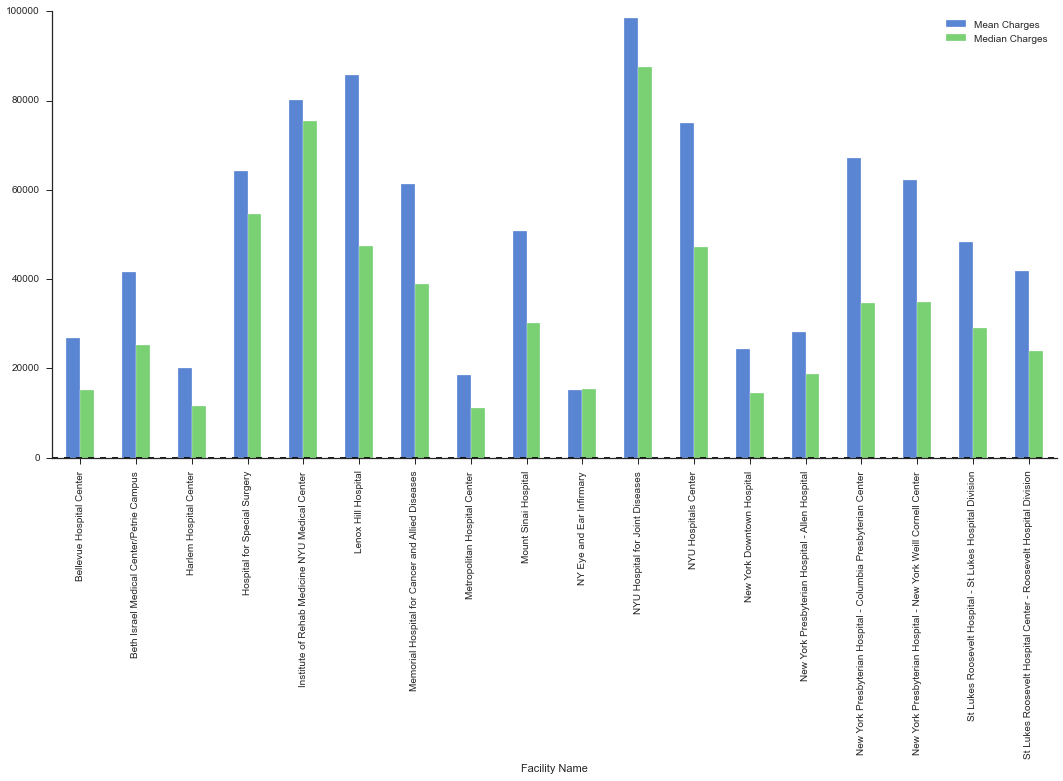

In [971]:
facility = df[['Facility Name','charges']].dropna()
facility_mean = facility.groupby('Facility Name').mean()
facility_median = facility.groupby('Facility Name').median()
facility_mean=facility_mean.rename(columns = {'charges':'Mean Charges'})
facility_median=facility_median.rename(columns = {'charges':'Median Charges'})
facility_median = facility_median['Median Charges']
facility_mandm = facility_mean.join(facility_median)
facility_mandm.plot(kind='bar', figsize=(18,8), grid = False, edgecolor = "white", alpha = 0.9)
sns.despine()

Now let's specifically look at cardiac cath at Mount Sinai vs. all other facilities

In [972]:
ccath = df[df['CCS Procedure Description'] == 'PERC TRANSLUM COR ANGIO']
ms_ccath = ccath[ccath['Facility Name'] == 'Mount Sinai Hospital']
other_ccath = ccath[ccath['Facility Name'] <> 'Mount Sinai Hospital']

In [973]:
ms_ccath['charges'].median()

35064.25

In [978]:
med_other_ccath = other_ccath[['Facility Name', 'charges']]
med_other_ccath= med_other_ccath.groupby('Facility Name').median().sort(columns='charges')
med_other_ccath

,charges
Facility Name,
Bellevue Hospital Center,29276.140
Beth Israel Medical Center/Petrie Campus,30204.425
St Lukes Roosevelt Hospital - St Lukes Hospital Division,39512.640
St Lukes Roosevelt Hospital Center - Roosevelt Hospital Division,40177.000
New York Presbyterian Hospital - New York Weill Cornell Center,42579.260
New York Presbyterian Hospital - Columbia Presbyterian Center,43090.835
Lenox Hill Hospital,47043.550
NYU Hospitals Center,87819.870


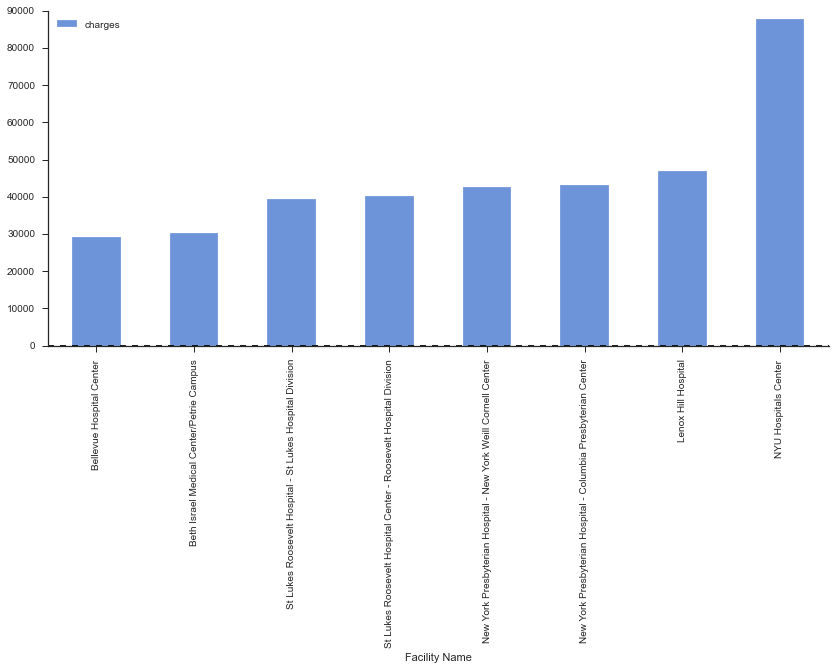

In [980]:
med_other_ccath.plot(kind='bar', figsize=(14,6), grid = False, edgecolor = "white", alpha = 0.8)
sns.despine()

On first glance, Mount Sinai seems to bill Medicaid fairly and NYU seems to be the outlier. Let's dig further:

In [982]:
nyu_ccath = cardiac_cath_aid[cardiac_cath_aid['Facility Name'] == 'NYU Hospitals Center']

Nope. Upon further examination, the sample size is only 1 and thus, this outlier should be removed from our calculations

In [1045]:
ccath = ccath[ccath['Facility Name'] <> 'NYU Hospitals Center']

In [1051]:
ccath1 = ccath[['Source of Payment 1', 'Facility Name']]

##Now, let's observe difference in charges by payment method (Medicaid vs. other payment)

Examine Cardiac Cath funded through Medicaid (2369 entries)

In [1061]:
#all facilities (2368 entries)
ccath_aid = ccath[(ccath['Source of Payment 1'] == 'Medicaid') | (ccath['Source of Payment 2'] == 'Medicaid') | (ccath['Source of Payment 3'] == 'Medicaid')]
ccath_oth = ccath[(ccath['Source of Payment 1'] <> 'Medicaid') | (ccath['Source of Payment 2'] <> 'Medicaid') | (ccath['Source of Payment 3'] <> 'Medicaid')]
ccath_aid2 = ccath_aid[['charges', 'Facility Name']]
ccath_oth2 = ccath_oth[['charges', 'Facility Name']]
#just Mount Sinai (1060 entries)
ms_ccath_aid = ccath_aid[ccath_aid['Facility Name'] == 'Mount Sinai Hospital']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x201a5dbd0>]], dtype=object)

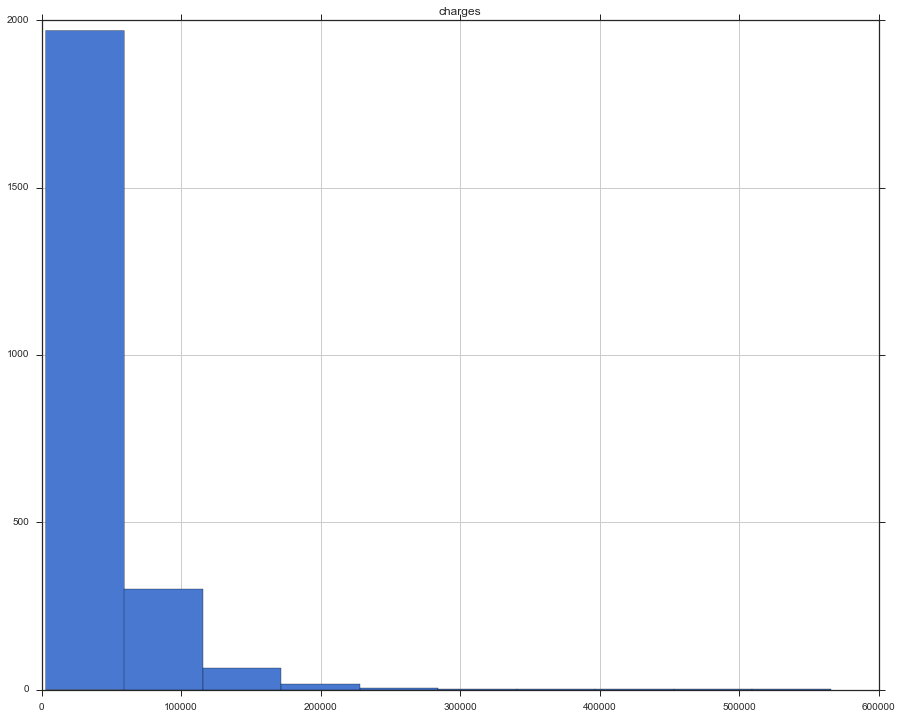

In [1073]:
ccath_aid2.hist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1d196d850>], dtype=object)

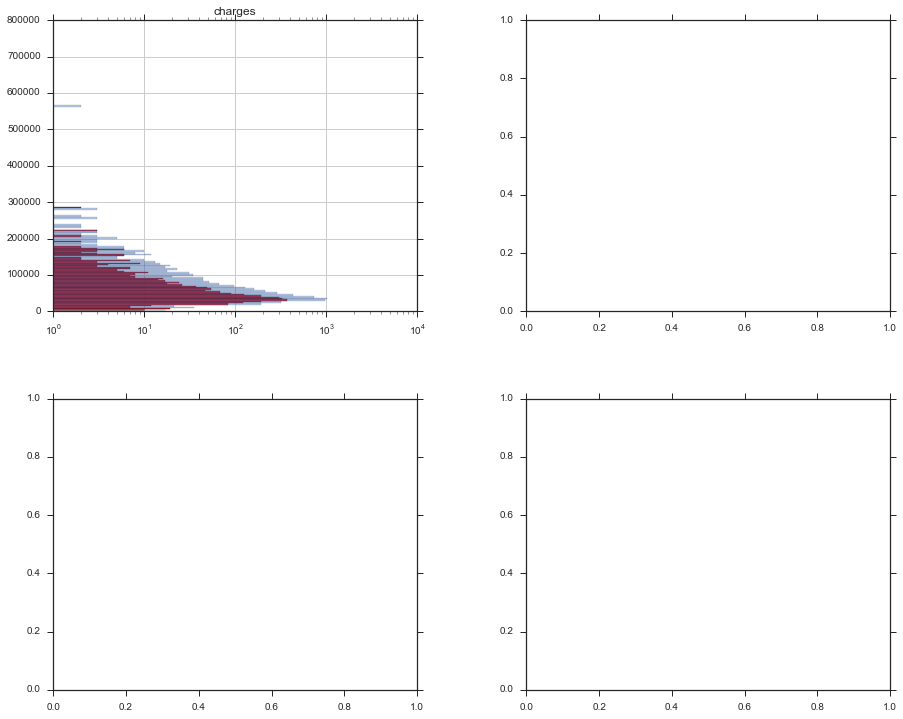

In [1062]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ccath_aid2.hist(log=True, orientation='horizontal', ax=axes[0,0], alpha=0.9, bins=150, color='r')
ccath_oth2.hist(log=True, orientation='horizontal', ax=axes[0,0], alpha=0.4, bins=150)

Examine Cardiac Cath procedures NOT funded through Medicaid (5151 entries)

In [986]:
#all facilities (5146 entries)
other_ccath = ccath[(ccath['Source of Payment 1'] <> 'Medicaid') | (ccath['Source of Payment 2'] <> 'Medicaid') | (ccath['Source of Payment 3'] <> 'Medicaid')]
#all facilities (3133 entries
other_ccath_aid = other_ccath[other_ccath['Facility Name'] <> 'Mount Sinai Hospital']

Compare cardiac cath procedures at Mount Sinai versus all other facilities

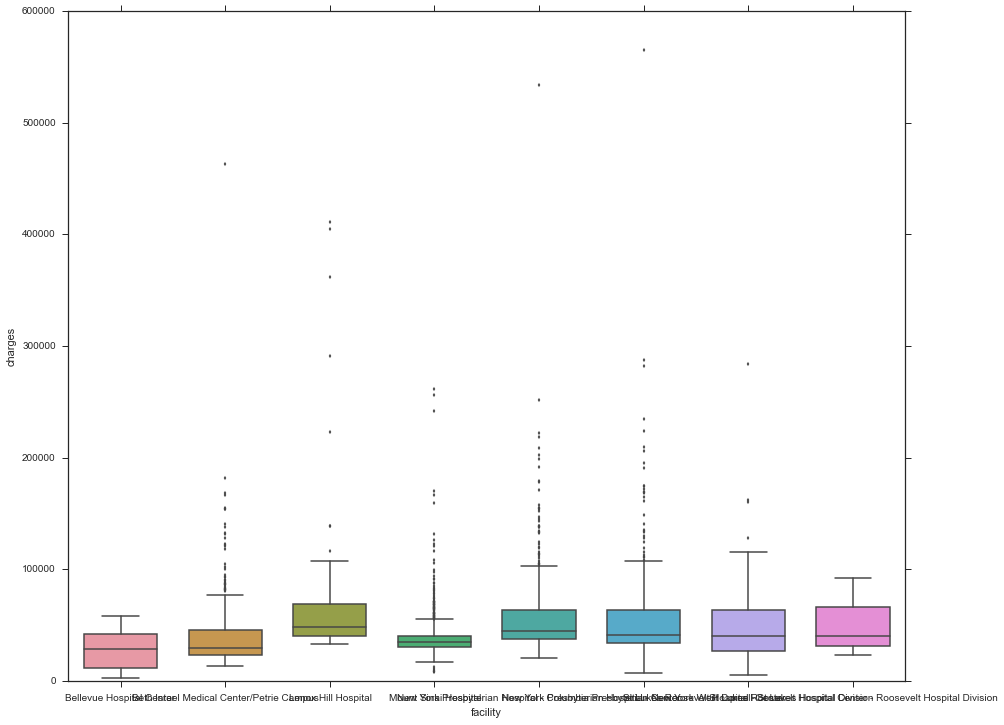

In [1042]:
ccath_aid1 = ccath_aid[['Facility Name', 'charges']]
ccath_aid1=ccath_aid1.rename(columns = {'Facility Name':'facility'})
sns.boxplot(ccath_aid1.charges, ccath_aid1.facility, alpha=None, widths=0.7, saturation=0.7)

##Now, let's explore emergency procedures versus elective ones (Mount Sinai vs. all others)

Comparing cardiac cath aid procedure - Emergency vs Elective (Mount sinai vs Others)

Let's condense those DataFrames to only include length of stay and the total charges and rename before performing the join operation

In [ ]:
#381 entries
ms_emer = ms_ccath_aid[ms_ccath_aid['Type of Admission'] == 'Emergency'] 
ms_emer = ms_emer[['Length of Stay']]
ms_emer = ms_emer.rename(columns = {'Length of Stay':'mslos'})

#679 entries
ms_elec = ms_ccath_aid[ms_ccath_aid['Type of Admission'] == 'Elective']
ms_elec = ms_elec[['Length of Stay']]
ms_elec = ms_elec.rename(columns = {'Length of Stay':'mslos'})

#2610 entries
oth_emer = other_ccath_aid[other_ccath_aid['Type of Admission'] == 'Emergency']
oth_emer = oth_emer[['Length of Stay']]
oth_emer=oth_emer.rename(columns = {'Length of Stay':'othlos'})

#519 entries
oth_elec = other_ccath_aid[other_ccath_aid['Type of Admission'] == 'Elective']
oth_elec = oth_elec[['Length of Stay']]
oth_elec=oth_elec.rename(columns = {'Length of Stay':'othlos'})

In [ ]:
sns.kdeplot(ms_emer.mslos, alpha=0.8)
sns.kdeplot(oth_emer.othlos)

In [ ]:
sns.kdeplot(ms_elec.mslos, alpha=0.8)
sns.kdeplot(oth_elec.othlos)

####Explore distribution of emergency procedures vs. elective

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
sns.color_palette("BrBG", 7)
sns.violinplot(ms_emer, groupby='mslos',  ax=axes[0,0]).set_ylim(-5,30)
sns.violinplot(oth_emer, groupby='othlos', ax=axes[0,1]).set_ylim(-5,30)
sns.violinplot(ms_elec, groupby='mslos',  ax=axes[1,0]).set_ylim(-5,30)
sns.violinplot(oth_elec, groupby='othlos', ax=axes[1,1]).set_ylim(-5,30)
sns.set_palette("husl")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x18ac144d0>], dtype=object)

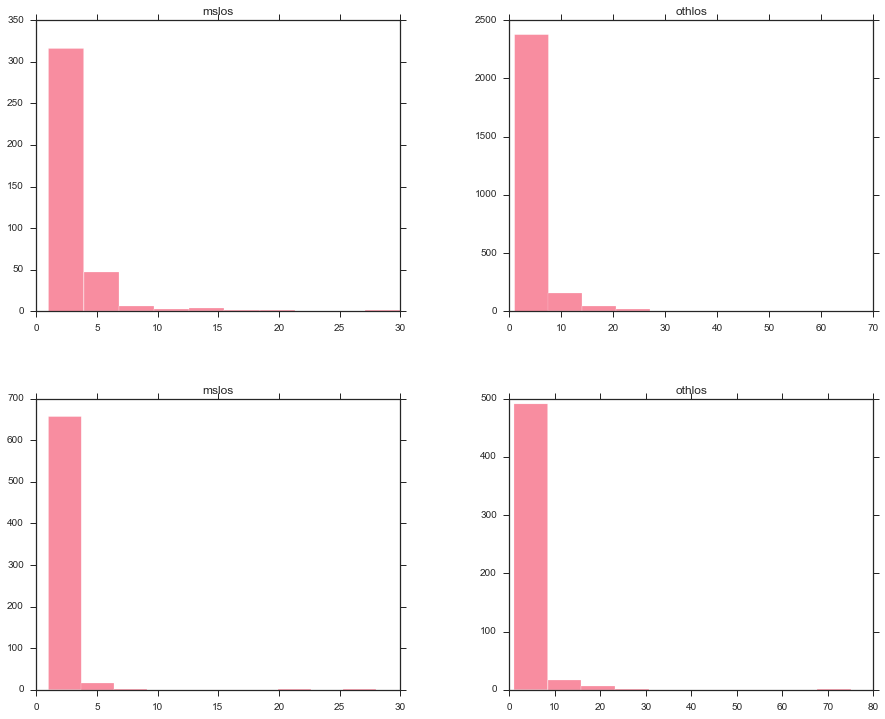

In [929]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ms_emer.hist(ax=axes[0,0], grid = False, edgecolor = "white", alpha = 0.8)
oth_emer.hist(ax=axes[0,1], grid = False, edgecolor = "white", alpha = 0.8)
ms_elec.hist(ax=axes[1,0], grid = False, edgecolor = "white", alpha = 0.8)
oth_elec.hist(ax=axes[1,1], grid = False, edgecolor = "white", alpha = 0.8)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x18b38d290>], dtype=object)

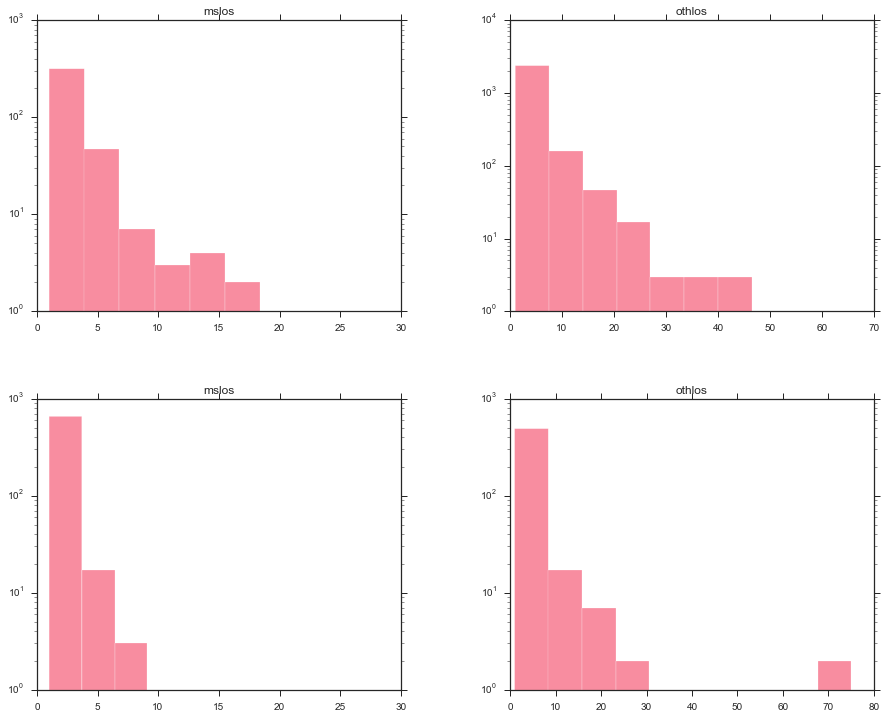

In [930]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ms_emer.hist(ax=axes[0,0], log=True, grid = False, edgecolor = "white", alpha = 0.8)
oth_emer.hist(ax=axes[0,1], log=True, grid = False, edgecolor = "white", alpha = 0.8)
ms_elec.hist(ax=axes[1,0], log=True, grid = False, edgecolor = "white", alpha = 0.8)
oth_elec.hist(ax=axes[1,1], log=True, grid = False, edgecolor = "white", alpha = 0.8)

In [ ]:
ms_emer.hist(ax=axes[0,0], grid = False, edgecolor = "white", alpha = 0.8)
oth_emer.hist(ax=axes[0,1], grid = False, edgecolor = "white", alpha = 0.8)
ms_elec.hist(ax=axes[1,0], grid = False, edgecolor = "white", alpha = 0.8)
oth_elec.hist(ax=axes[1,1], grid = False, edgecolor = "white", alpha = 0.8)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x19dd17610>], dtype=object)

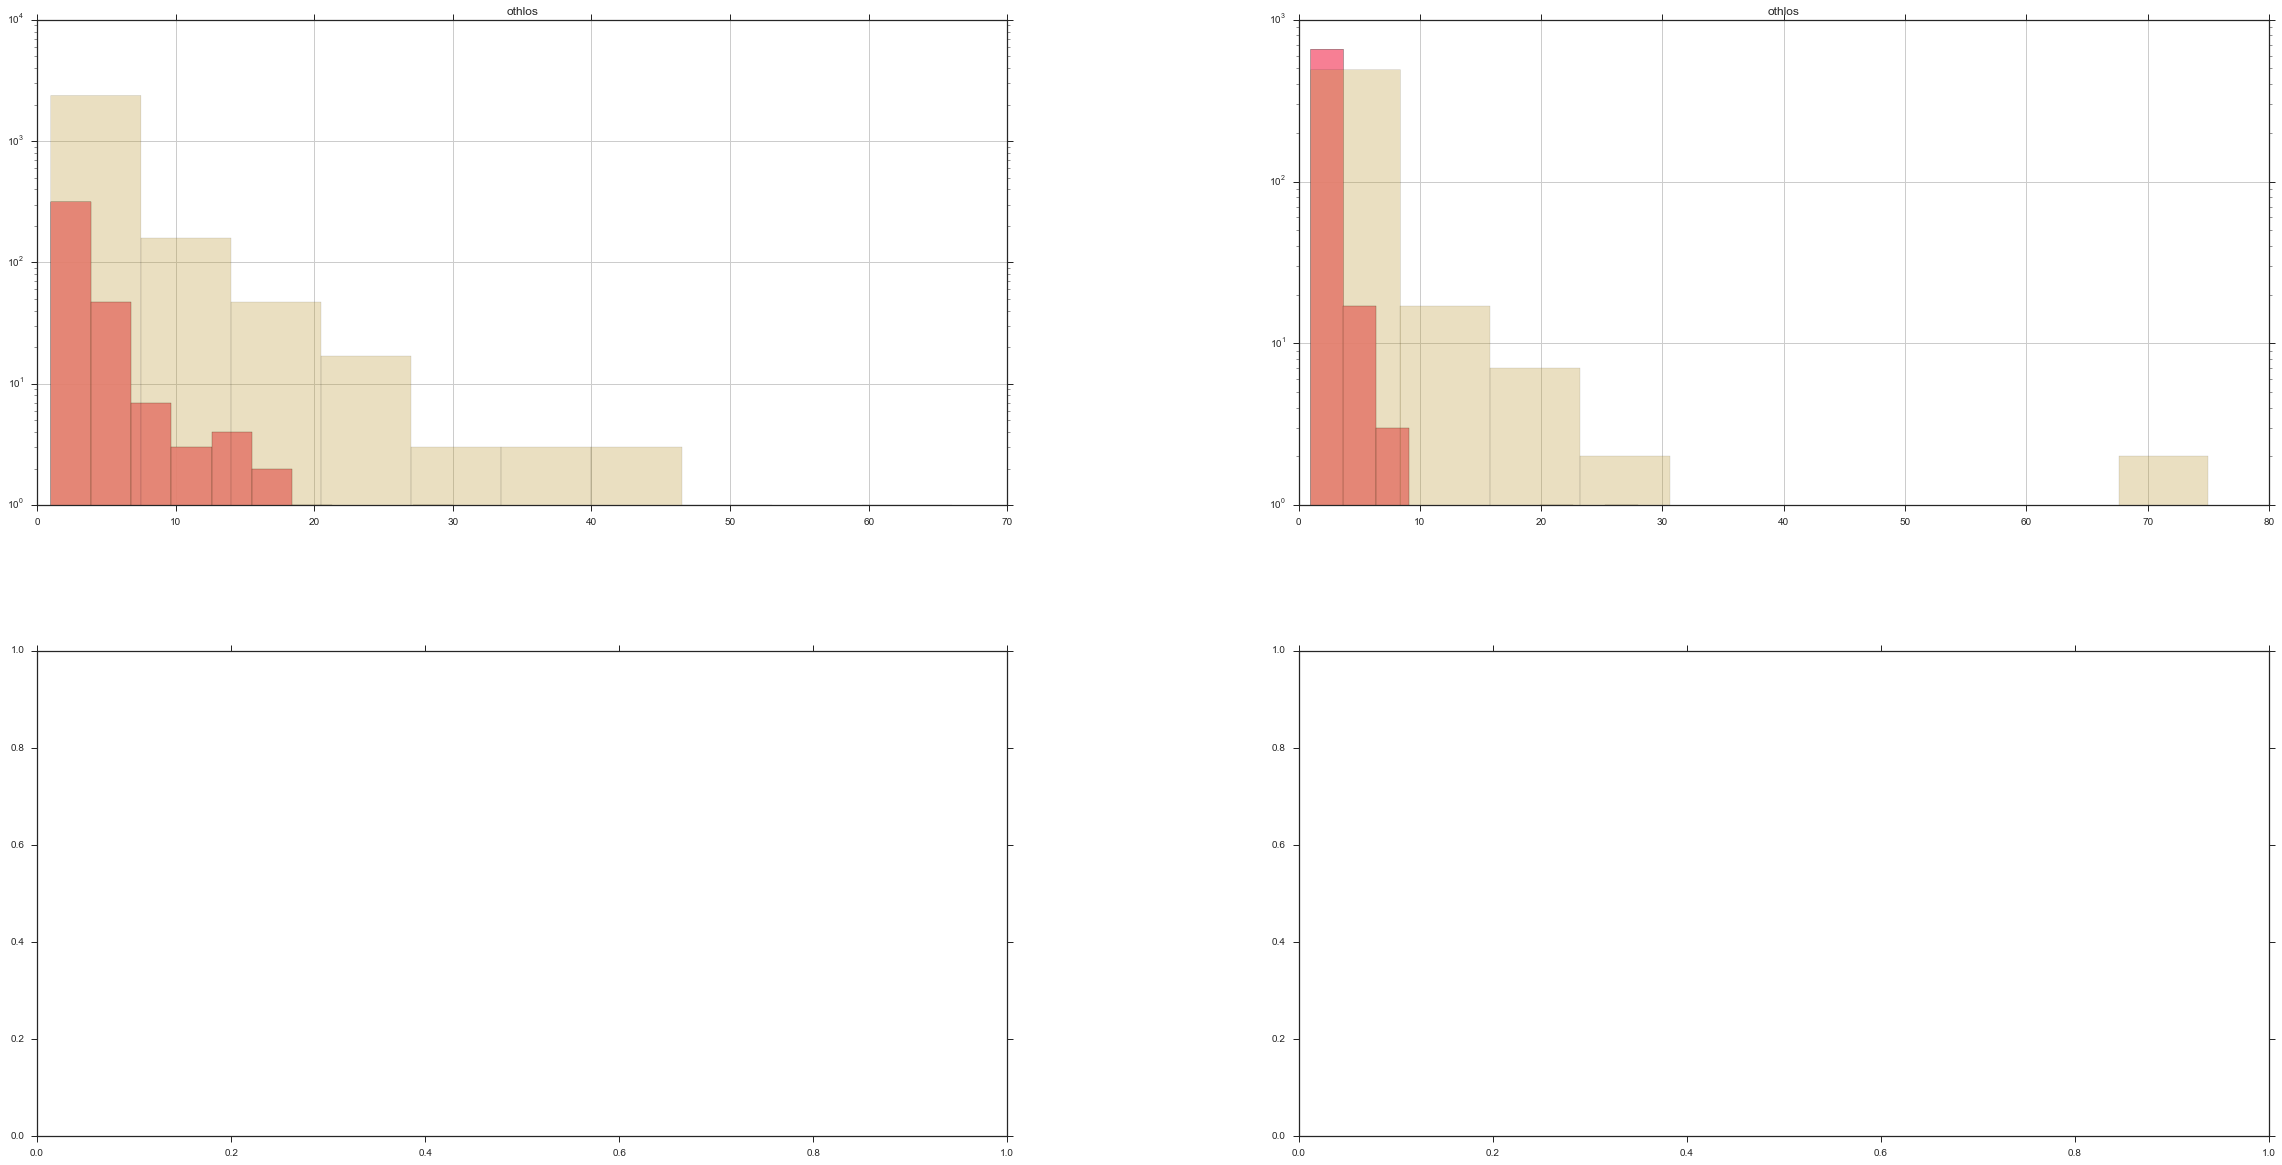

In [960]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ms_emer.hist(log=True, ax=axes[0,0], alpha=0.9)
oth_emer.hist(log=True, ax=axes[0,0], alpha=0.3)
ms_elec.hist(log=True, ax=axes[0,1], alpha=0.9)
oth_elec.hist(log=True, ax=axes[0,1], alpha=0.3)

####Now lets look at the reverse — for longer than average length of stay, what's the likelyhood of being considered Emergency vs. Elective

In [932]:
ccath_los = ccath_aid[['Type of Admission','Length of Stay','Facility Name','charges']]
ccath_los = ccath_los[ccath_los['Type of Admission'] <> 'Trauma']
ccath_los = ccath_los[(ccath_los['Type of Admission'] == 'Emergency') | (ccath_los['Type of Admission'] == 'Elective')]
#ccath_los = ccath_los.rename(columns = {'Type of Admission':'toa'})
#ccath_los = ccath_los.rename(columns = {'Length of Stay':'los'})
#ccath_los = ccath_los.rename(columns = {'Facility Name':'fn'})

In [934]:
em_ccath_los = ccath_los[ccath_los['Type of Admission'] == 'Emergency']
el_ccath_los = ccath_los[ccath_los['Type of Admission'] == 'Elective']

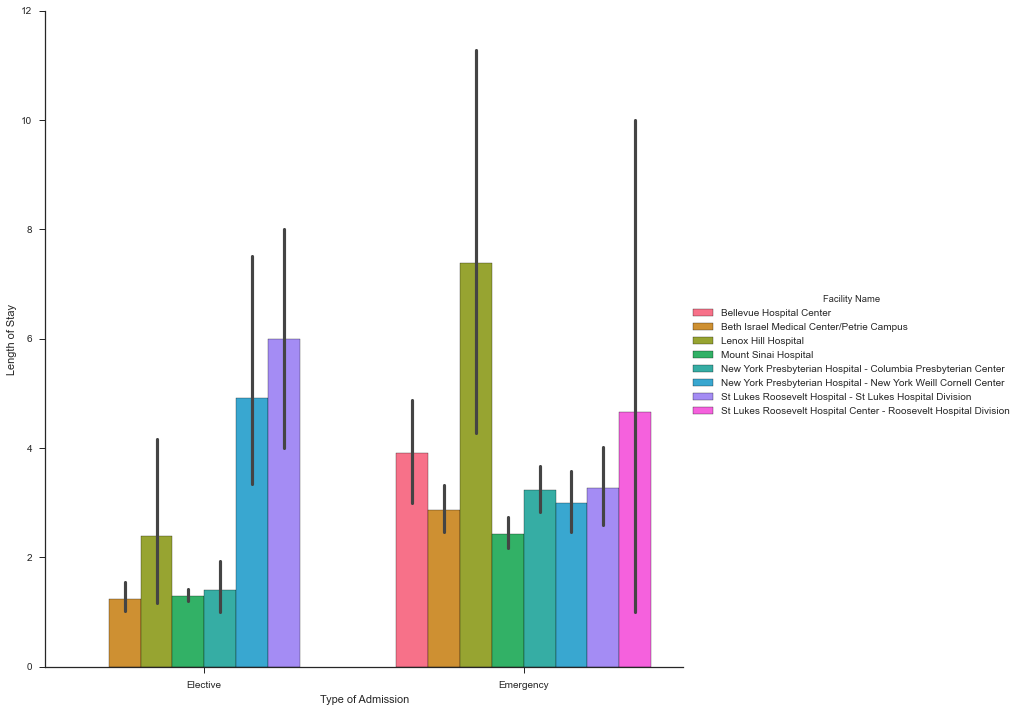

In [948]:
sns.factorplot("Type of Admission", "Length of Stay", "Facility Name", ccath_los, size=10)

###Now let's explore other predictive factors that correlate to procedures

In [937]:
columns=['Age Group', 'Gender', 'Discharge Day of Week', 'Race', 'APR Risk of Mortality']
las_df = df[columns]
las_df=las_df.rename(columns = {'Age Group':'agegroup'})
las_df=las_df.rename(columns = {'Gender':'sex'})
las_df=las_df.rename(columns = {'Discharge Day of Week':'dday'})
las_df=las_df.rename(columns = {'Race':'race'})
las_df=las_df.rename(columns = {'APR Risk of Mortality':'rom'})

####Binarize variables

In [ ]:
age_dummies = pd.get_dummies(las_df['agegroup'])
sex_dummies = pd.get_dummies(las_df['sex'])
dday_dummies = pd.get_dummies(las_df['dday'])
race_dummies = pd.get_dummies(las_df['race'])
rom_dummies = pd.get_dummies(las_df['rom'])
df1 = las_df.join(age_dummies)
df2 = df1.join(sex_dummies)
df3 = df2.join(dday_dummies)
df4 = df3.join(race_dummies)
df5 = df4.join(rom_dummies)
df5= df5.drop('agegroup',1)
df5= df5.drop('sex',1)
df5= df5.drop('dday',1)
df5= df5.drop('race',1)
df5= df5.drop('rom',1)
df5 = df5.drop('0 to 17', 1)
df5 = df5.drop('U', 1)
df5 = df5.drop('MON', 1)
df5 = df5.drop('Other Race', 1)
df5 = df5.drop('Extreme', 1)
df5.head(1)

####Perform test-train split

In [ ]:
from sklearn.cross_validation import train_test_split
X = df5
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.30, random_state=12345)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

###Lasso (L1) Regularization

In [345]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [350]:
lasso = Lasso(alpha=0.0001, normalize=True)
lasso.fit(X_train, y_train)
lasso.coef_

array([  -2179.79302309,    2327.09355481,    5288.3893455 ,
        -10124.50809636,   -5021.53402666,   -3148.04229304,
         -3175.42748397,   -7338.81386189,   -7168.0890949 ,
         -1852.56137581,    1192.33771265,    -992.84361741,
         -6761.68767285,  -21742.3264902 ,    3312.35338388,
        -91172.56377282, -137100.28238782, -118460.69497229])

In [351]:
preds = lasso.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

76498.496476965025

###Linear Regression Coefficients

In [352]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [353]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.coef_
preds = lm.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, preds))

76498.759227487084

###Feature Selection

In [354]:
lm = LinearRegression()
from sklearn.feature_selection import RFE
selector = RFE(lm)
selector.fit(X_train, y_train)
selector.n_features_
selector.support_
selector.ranking_

array([ 7,  5,  3,  1,  1,  1,  8,  2,  1,  9,  6, 10,  1,  1,  4,  1,  1,
        1])

In [355]:
from sklearn.feature_selection import RFECV
selector = RFECV(lm, cv=3, scoring='mean_squared_error')
selector.fit(X, y)
selector.n_features_
selector.support_
selector.ranking_

array([17, 12, 11,  7,  5,  6, 14, 10,  9, 15, 18, 16,  8,  4, 13,  3,  1,
        2])

How does R-square change with alpha score?

In [384]:
alpha = 0.0000000001
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
print lasso
print "r^2 score : %f" % (1 - np.linalg.norm(y_test - y_pred_lasso) ** 2
                                      / np.linalg.norm(y_test) ** 2)

Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)
r^2 score : 0.397514


####R2 tells us these various factors do a marginal job in explaining the cost of the procedures

In [385]:
lasso.coef_

array([  -2179.92944731,    2327.18173474,    5288.39904176,
        -10124.64651788,   -5150.29914963,   -3276.89825784,
         -3175.83335837,   -7339.23931181,   -7168.54405965,
         -1852.9788669 ,    1192.07352931,    -993.26822652,
         -6761.78033685,  -21750.53575323,    3312.42647203,
        -91173.30924173, -137101.03312351, -118461.43990203])

In [386]:
lasso.coef_ != 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [387]:
lasso = linear_model.Lasso(normalize=True, alpha=.1)
lasso.fit(X_train, y_train)
pass

In [388]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()

linreg.fit(X_train, y_train)
r2_ols_train = linreg.score(X_train, y_train)
r2_ols = linreg.score(X_train, y_train)

lasso.fit(X_train, y_train)
r2_lasso_train = lasso.score(X_train, y_train)
r2_lasso = lasso.score(X_train, y_train)

In [389]:
results = """\
      | TRAINING | TESTING
------+----------+---------
OLS   | {:.2%}   | {:.2%}
------+----------+---------
Lasso | {:.2%}   | {:.2%}
---------------------------
""".format(r2_ols_train, r2_ols, r2_lasso_train, r2_lasso)
print(results)

      | TRAINING | TESTING
------+----------+---------
OLS   | 15.75%   | 15.75%
------+----------+---------
Lasso | 15.75%   | 15.75%
---------------------------



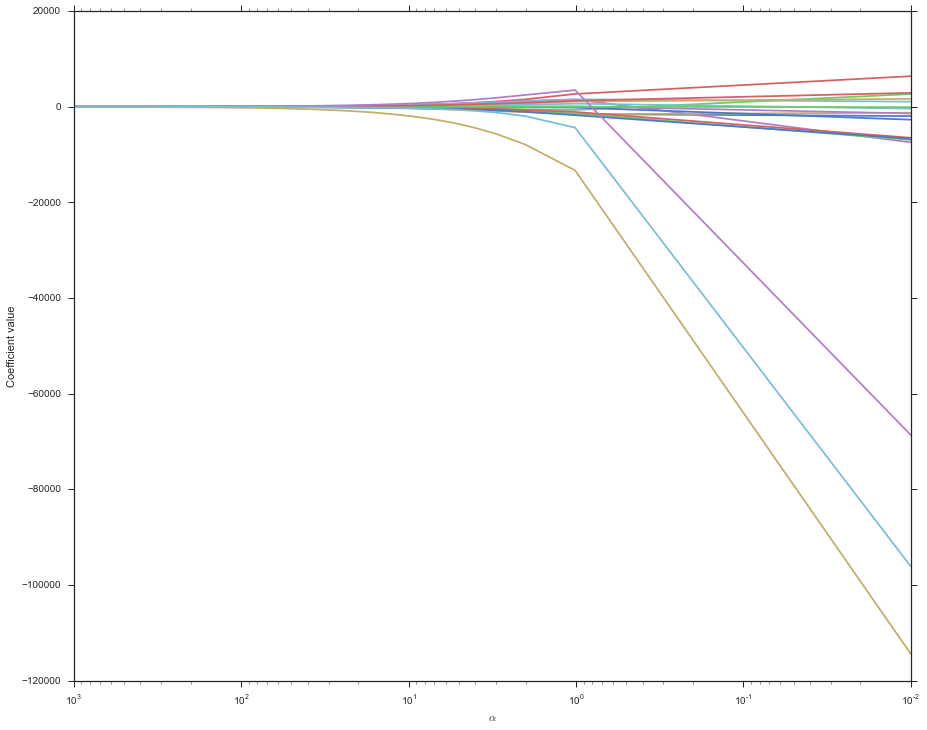

In [390]:
alphas = np.linspace(.01, 1000., 1000)
alphas, coefs, _= lasso.path(X_train, y_train, alphas=alphas)

fig,ax = plt.subplots()
ax.plot(alphas, coefs.T, )
ax.set_xscale('log')
ax.set_xlim(alphas.max(), alphas.min())
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Coefficient value')
pass

In [391]:
mod = sm.OLS(y, X)
res = mod.fit() 
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     5734.
Date:                Sat, 18 Apr 2015   Prob (F-statistic):               0.00
Time:                        12:52:53   Log-Likelihood:            -2.1356e+06
No. Observations:              168123   AIC:                         4.271e+06
Df Residuals:                  168105   BIC:                         4.271e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
18 to 29               -1812